In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             roc_auc_score, 
                             roc_curve,
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             classification_report, 
                             confusion_matrix)
from tqdm import tqdm

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# 1. Đọc dữ liệu
df_train = pd.read_parquet('train.parquet')
df_valid = pd.read_parquet('validation.parquet')
df_test  = pd.read_parquet('test.parquet')

In [4]:



# 2. Cột loại bỏ
cols_to_drop = [
    'fraud',
    'ngay_hhluc_khang', 'ngay_hhluc_vitri_ddo', 'ngay_hhluc_diemdo', 'ngay_hhluc',
    'id_bcs', 'ngay_kdinh', 'loai_chiso', 'ngay_hluc_diem_do', 'ngay_hluc_vitri_ddo',
    'thang_csuat_ddo', 'ngay_hluc_khang', 'gia_tri', 'loai_giatri', 'kimua_cspk',
    'id_ddo', 'ma_dviqly', 'so_cot', 'so_hop', 'ma_dvictren', 'ky', 'thang', 'nam',
    'sluong_ttiep', 'sluong_trphu', 'thd_le', 'ma_cnang_chiso', 'ngay_bdong',
    'id_khang', 'so_pha', 'ngay_tao_chiso', 'nguoi_tao_chiso', 'ngay_sua_chiso',
    'nguoi_sua_chiso', 'ngay_hluc'
]

# 3. Tách X, y
X_train = df_train.drop(columns=cols_to_drop)
y_train = df_train['fraud']
X_valid = df_valid.drop(columns=cols_to_drop)
y_valid = df_valid['fraud']
X_test = df_test.drop(columns=cols_to_drop)
y_test = df_test['fraud']

# Decision tree

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Tao custom metrix
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

# Tạo custom transformer để thực hiện oversampling và undersampling
class ResampleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, oversampler, undersampler):
        self.oversampler = oversampler
        self.undersampler = undersampler

    def fit(self, X, y):
        # Không cần fit gì ở đây, chỉ cần trả về chính X, y
        return self

    def transform(self, X, y=None):
        # Áp dụng oversampling rồi đến undersampling nếu y không phải None
        if y is not None:
            X_res, y_res = self.oversampler.fit_resample(X, y)
            X_res, y_res = self.undersampler.fit_resample(X_res, y_res)
            return X_res, y_res
        return X  # Nếu y là None, chỉ trả về X


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

SEED = 42

# Chuẩn bị dữ liệu
X = pd.concat([X_train, X_valid], axis=0)
y = pd.concat([y_train, y_valid], axis=0)

# Sử dụng StratifiedKFold để đảm bảo tỷ lệ lớp
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Khởi tạo mô hình Decision Tree
model = DecisionTreeClassifier(
    criterion='gini',        
    max_depth=10,             # Giới hạn độ sâu của cây
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=SEED
)

In [9]:

# Khởi tạo các phương pháp resampling
oversampler = RandomOverSampler(sampling_strategy=0.03, random_state=SEED)
undersampler = RandomUnderSampler(sampling_strategy=0.03, random_state=SEED)


In [10]:

# Tạo pipeline hoàn chỉnh sử dụng custom transformer
full_pipeline = Pipeline([
    ('resample', ResampleTransformer(oversampler, undersampler)),
    ('model', model)
])

# Đánh giá mô hình bằng cross-validation với custom transformer
print("Performing cross-validation with Augmentation...")
cross_val_results = cross_validate(
    full_pipeline,
    X,
    y,
    cv=skf,
    scoring=custom_metric,
    verbose=1
)

# In ra kết quả cross-validation
print(f'Cross-validation pAUC scores: {cross_val_results["test_score"]}')
print(f'Mean pAUC: {cross_val_results["test_score"].mean():.4f}, Std: {cross_val_results["test_score"].std():.4f}')

# Huấn luyện mô hình cuối cùng trên toàn bộ dữ liệu
print("Training final model on the entire combined dataset...")
full_pipeline.fit(X, y)


Performing cross-validation with Augmentation...
Cross-validation pAUC scores: [0.19088785 0.19081494 0.19083365 0.19078514 0.19082751]
Mean pAUC: 0.1908, Std: 0.0000
Training final model on the entire combined dataset...


Pipeline(steps=[('resample',
                 ResampleTransformer(oversampler=RandomOverSampler(random_state=42,
                                                                   sampling_strategy=0.03),
                                     undersampler=RandomUnderSampler(random_state=42,
                                                                     sampling_strategy=0.03))),
                ('model',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=5,
                                        min_samples_split=10,
                                        random_state=42))])

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

y_pred = full_pipeline.predict(X_test)
y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]  # Xác suất của lớp dương

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# In kết quả đánh giá
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9908
Precision: 0.8347
Recall: 0.3412
F1-Score: 0.4844
ROC AUC: 0.9878
Confusion Matrix:
[[4375704    3794]
 [  36998   19165]]


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


y_proba = full_pipeline.predict_proba(X_test)[:, 1]  # Xác suất thuộc class 1 (fraud)

threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)


accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
roc_auc   = roc_auc_score(y_test, y_proba)
cm        = confusion_matrix(y_test, y_pred)

print(f"Threshold: {threshold}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")
print("Confusion Matrix:")
print(cm)


Threshold: 0.3
Accuracy:  0.9886
Precision: 0.5437
Recall:    0.6246
F1-Score:  0.5813
ROC AUC:   0.9878
Confusion Matrix:
[[4350056   29442]
 [  21086   35077]]


In [14]:
resample = ResampleTransformer(oversampler, undersampler)
X_train_res, y_train_res = resample.transform(X_train, y_train)

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss

import numpy as np


max_depth_range = range(1, 21)

train_acc = []
val_acc = []
train_loss = []
val_loss = []

for depth in max_depth_range:
    model = DecisionTreeClassifier(
        max_depth=depth,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    # Huấn luyện trên dữ liệu đã resample
    model.fit(X_train_res, y_train_res)

    # Dự đoán
    y_train_pred = model.predict(X_train_res)
    y_valid_pred = model.predict(X_valid)
    y_train_proba = model.predict_proba(X_train_res)
    y_valid_proba = model.predict_proba(X_valid)

    # Accuracy
    train_acc.append(accuracy_score(y_train_res, y_train_pred))
    val_acc.append(accuracy_score(y_valid, y_valid_pred))

    # Log loss
    train_loss.append(log_loss(y_train_res, y_train_proba))
    val_loss.append(log_loss(y_valid, y_valid_proba))


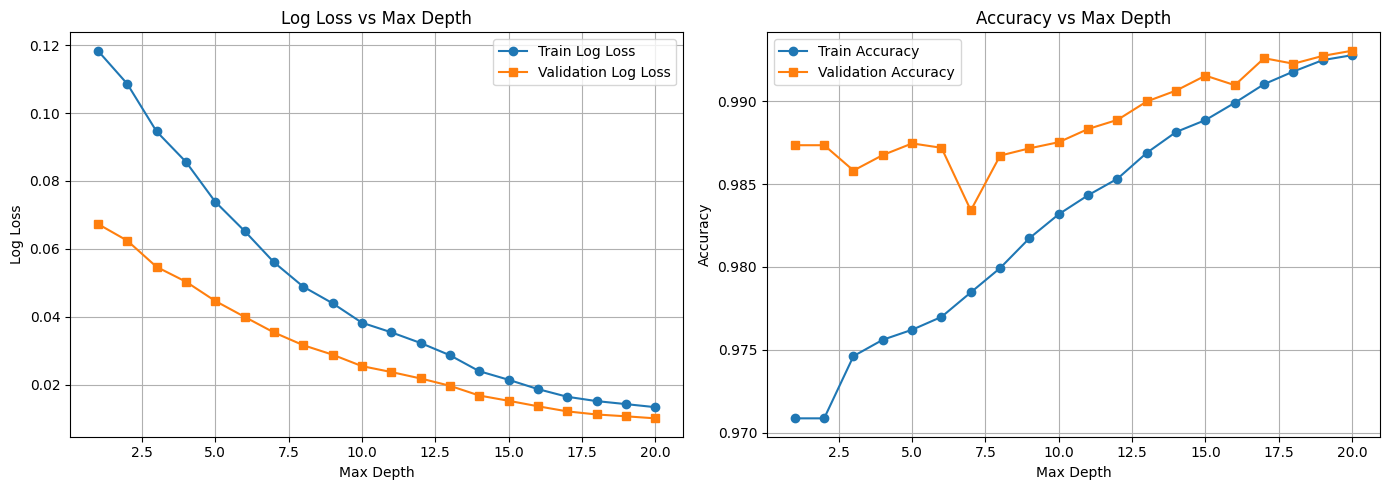

In [19]:
import matplotlib.pyplot as plt
# --- VẼ ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
# Log Loss
ax[0].plot(max_depth_range, train_loss, label="Train Log Loss", marker='o')
ax[0].plot(max_depth_range, val_loss, label="Validation Log Loss", marker='s')
ax[0].set_title("Log Loss vs Max Depth")
ax[0].set_xlabel("Max Depth")
ax[0].set_ylabel("Log Loss")
ax[0].legend()
ax[0].grid(True)
# Accuracy
ax[1].plot(max_depth_range, train_acc, label="Train Accuracy", marker='o')
ax[1].plot(max_depth_range, val_acc, label="Validation Accuracy", marker='s')
ax[1].set_title("Accuracy vs Max Depth")
ax[1].set_xlabel("Max Depth")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(True)



plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   4379642
           1       0.84      0.16      0.27     56019

    accuracy                           0.99   4435661
   macro avg       0.92      0.58      0.63   4435661
weighted avg       0.99      0.99      0.99   4435661



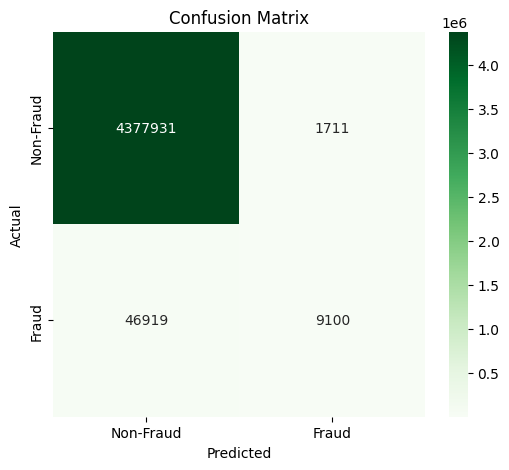

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán trên tập test
y_pred = full_pipeline.predict(X_test)

# Đánh giá mô hình với classification report và confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Vẽ confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Định nghĩa độ đo tùy chỉnh (Partial AUC)
def custom_metric(y_true, y_pred_proba):
    min_tpr = 0.80  # Ngưỡng TPR tối thiểu
    max_fpr = abs(1 - min_tpr)  # Ngưỡng FPR tối đa
    
    v_gt = abs(y_true - 1)  # Chuyển đổi y_true thành lớp tích cực (1) và lớp tiêu cực (0)
    v_pred = np.array([1.0 - x for x in y_pred_proba])  # Chuyển đổi xác suất dự đoán thành lớp tiêu cực
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)  # Tính AUC của phần có FPR giới hạn
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)  # Điều chỉnh AUC

    return partial_auc

# Lấy xác suất dự đoán của lớp tích cực (Fraud)
y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]  # Dự đoán xác suất lớp tích cực (Fraud)

# Tính độ đo tùy chỉnh trên tập test
custom_auc_score = custom_metric(y_test, y_pred_proba)

# In kết quả độ đo tùy chỉnh
print(f'Custom pAUC Score: {custom_auc_score}')
print(f'AUC Score: {roc_auc_score(y_test, y_pred_proba)}')

Custom pAUC Score: 0.19082833657887005
AUC Score: 0.987763830088882


In [11]:
# Lấy xác suất dự đoán của lớp tích cực (Fraud)
y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]  # Dự đoán xác suất lớp tích cực (Fraud)
# In kết quả 
print(f'AUC Score: {roc_auc_score(y_test, y_pred_proba)}')


AUC Score: 0.9326359675715363


Text(0, 0.5, 'True Positive Rate')

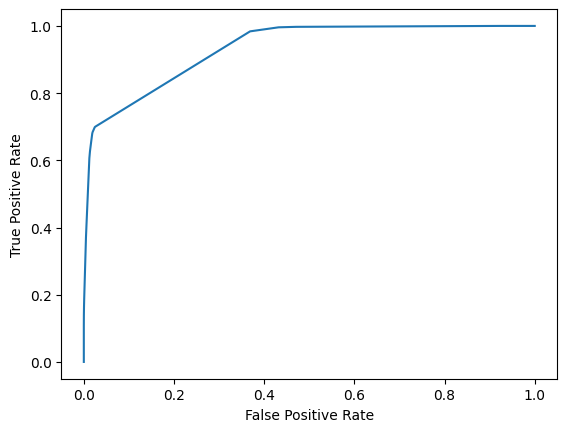

In [12]:
# Ve ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [13]:
Features = [col for col in df.columns if col not in cols_to_drop]
print(Features)

['id_chiso', 'ma_ddo', 'bcs_chiso', 'hs_nhan', 'so_cto_chiso', 'chiso_cu', 'chiso_moi', 'san_luong', 'ma_ttcto', 'ngay_dky', 'ngay_cky', 'sluong_1', 'sluong_2', 'sluong_3', 'ma_tram', 'ma_cto', 'so_cto_hso_cto', 'ma_bdong', 'dong_dien', 'dien_ap', 'vh_cong', 'ma_cloai', 'ten_khang', 'ma_khang', 'dia_chi', 'csuat', 'so_cto_csuat_ddo']


In [14]:
print(len(Features))
print(len(model.feature_importances_))


27
27


C:\Users\HOME\AppData\Local\Temp\ipykernel_7256\514820566.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


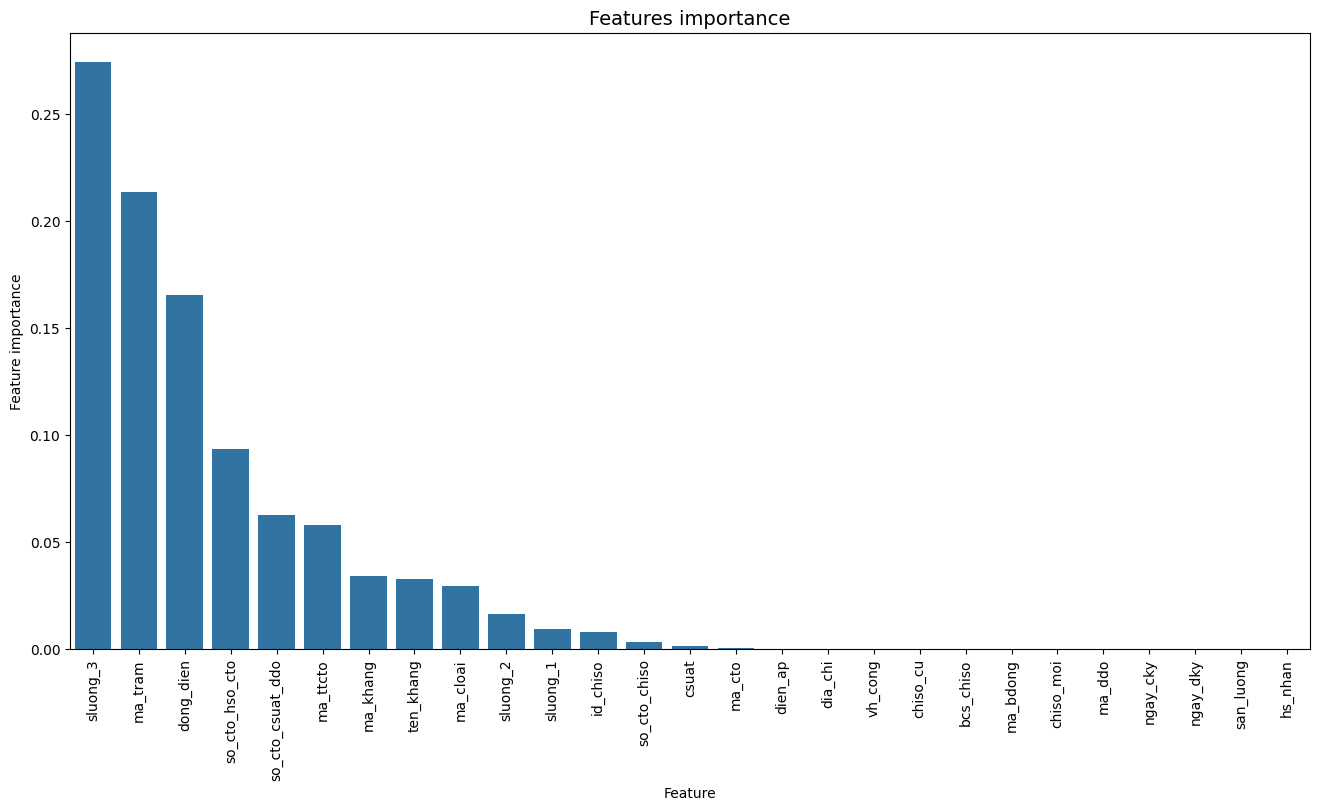

In [15]:
tmp = pd.DataFrame({'Feature': Features, 'Feature importance': model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (16,8))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [16]:
'ngay_bdong',
'id_khang',
'so_pha',
'ngay_hluc_khang',
'ngay_hluc_vitri_ddo',
'ngay_hluc_diem_do',
'ngay_tao_chiso',
'nguoi_tao_chiso',
'ngay_sua_chiso',
'nguoi_sua_chiso',
'ngay_hluc'

'ngay_hluc'

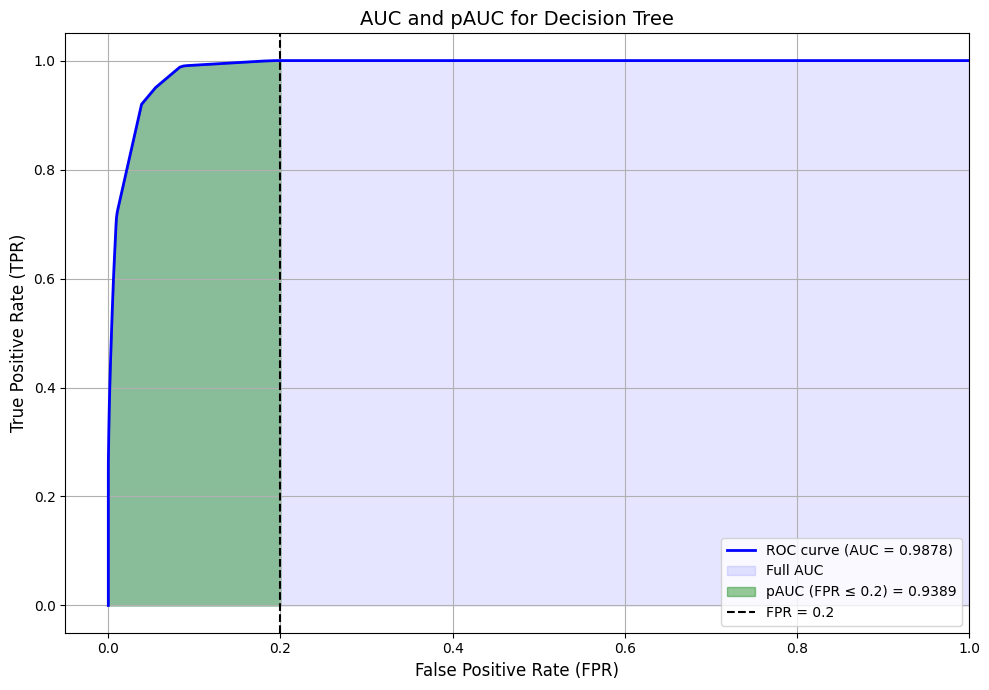

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Dữ liệu đầu vào (đã train model)
y_true = y  # true labels
y_scores = full_pipeline.predict_proba(X)[:, 1]  # xác suất nhãn 1 (fraud)

# Tính ROC curve và AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Tính pAUC với FPR ≤ 0.2
max_fpr = 0.2
mask = fpr <= max_fpr
fpr_trunc = fpr[mask]
tpr_trunc = tpr[mask]

# Nội suy thêm điểm tại FPR = 0.2 nếu cần
if fpr_trunc[-1] < max_fpr and len(fpr_trunc) > 1:
    slope = (tpr_trunc[-1] - tpr_trunc[-2]) / (fpr_trunc[-1] - fpr_trunc[-2])
    tpr_at_02 = tpr_trunc[-1] + slope * (max_fpr - fpr_trunc[-1])
    fpr_trunc = np.append(fpr_trunc, max_fpr)
    tpr_trunc = np.append(tpr_trunc, tpr_at_02)

pauc = auc(fpr_trunc, tpr_trunc)
pauc_normalized = pauc / max_fpr

# Vẽ biểu đồ
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')

# Full AUC background
plt.fill_between(fpr, tpr, alpha=0.1, color='blue', label='Full AUC')

# pAUC highlight
plt.fill_between(fpr_trunc, tpr_trunc, alpha=0.4, color='green',
                 label=f'pAUC (FPR ≤ {max_fpr}) = {pauc_normalized:.4f}')

# FPR = 0.2 line
plt.axvline(x=max_fpr, color='black', linestyle='--', label=f'FPR = {max_fpr}')

# Trang trí
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('AUC and pAUC for Decision Tree', fontsize=14)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.grid(True)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()


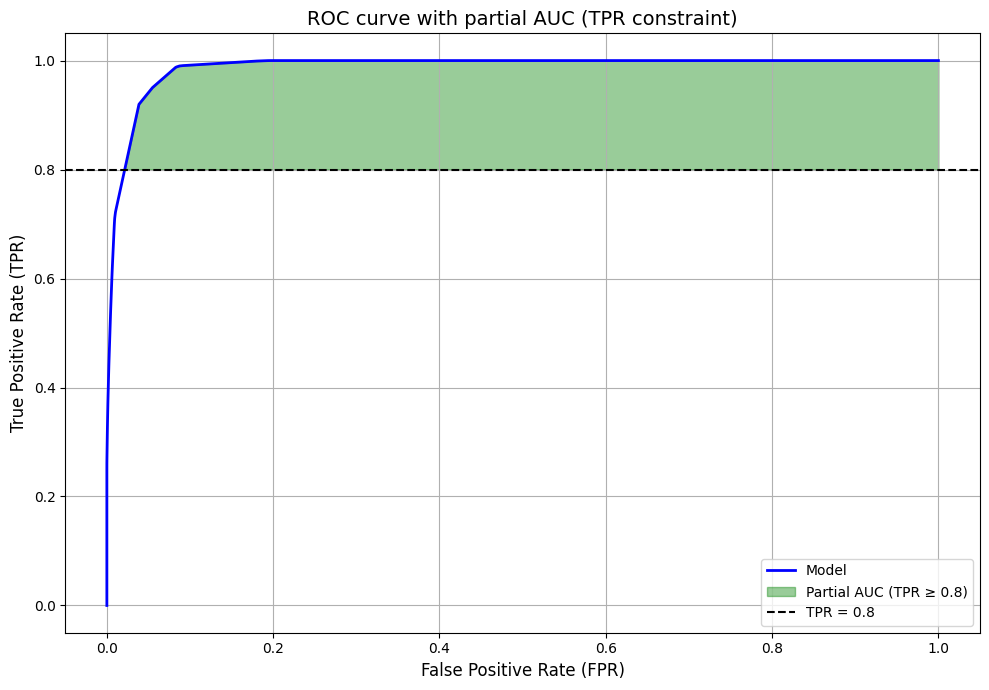

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Dữ liệu đã train
y_true = y  # true labels
y_scores = full_pipeline.predict_proba(X)[:, 1]

# Tính ROC curve (dữ liệu lấy từ đoạn code của bạn)
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# --- Phần mới: partial AUC với ngưỡng TPR ---
tpr0 = 0.8  # ví dụ giống hình gốc

# Chọn các đoạn TPR ≥ TPR0
mask = tpr >= tpr0
fpr_partial = fpr[mask]
tpr_partial = tpr[mask]

# Nội suy thêm điểm nếu cần
if len(fpr_partial) > 0 and tpr_partial[0] > tpr0:
    idx = np.where(mask)[0][0]
    tpr_prev, fpr_prev = tpr[idx - 1], fpr[idx - 1]
    tpr_curr, fpr_curr = tpr[idx], fpr[idx]
    slope = (tpr_curr - tpr_prev) / (fpr_curr - fpr_prev)
    fpr_interp = fpr_prev + (tpr0 - tpr_prev) / slope
    fpr_partial = np.insert(fpr_partial, 0, fpr_interp)
    tpr_partial = np.insert(tpr_partial, 0, tpr0)

# Vẽ giống hình gốc
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label='Model')

# Vẽ vùng partial AUC
plt.fill_between(fpr_partial, tpr_partial, tpr0, alpha=0.4, color='green', label=f'Partial AUC (TPR ≥ {tpr0})')

# Đường TPR0
plt.axhline(y=tpr0, color='black', linestyle='--', label=f'TPR = {tpr0}')

plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC curve with partial AUC (TPR constraint)', fontsize=14)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(True)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()


PREPROCESSING AND IMBALANCE

In [3]:
# Cột loại bỏ trước huấn luyện
cols_to_drop = [
    'fraud',
    'ngay_hhluc_khang',
    'ngay_hhluc_vitri_ddo',
    'ngay_hhluc_diemdo',
    'ngay_hhluc',
    'id_bcs',
    'ngay_kdinh',
    'loai_chiso',
    'ngay_hluc_diem_do',
    'ngay_hluc_vitri_ddo',
    'thang_csuat_ddo',
    'ngay_hluc_khang',
    'gia_tri',
    'loai_giatri',
    'kimua_cspk',
    'id_ddo',
    'ma_dviqly',
    'so_cot',
    'so_hop',
    'ma_dvictren',
    'ky',
    'thang',
    'nam',
    'sluong_ttiep',
    'sluong_trphu',
    'thd_le',
    'ma_cnang_chiso',
    'ngay_bdong',
    'id_khang',
    'so_pha',
    'ngay_tao_chiso',
    'nguoi_tao_chiso',
    'ngay_sua_chiso',
    'nguoi_sua_chiso',
    'ngay_hluc'

]

# Chuẩn bị X và y từ dữ liệu gốc
X_raw = df.drop(columns=cols_to_drop)
y_raw = df['fraud']

# Mã hóa các cột object để mô hình có thể học được
cat_cols2 = X_raw.select_dtypes(include=['object']).columns.tolist()
oe2 = OrdinalEncoder()
X_raw[cat_cols2] = oe2.fit_transform(X_raw[cat_cols2].astype(str))

In [4]:
X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
    X_raw, y_raw, test_size=0.4, random_state=42, stratify=y_raw)

X_test_raw, X_valid_raw, y_test_raw, y_valid_raw = train_test_split(
    X_temp_raw, y_temp_raw, test_size=0.5, random_state=42, stratify=y_temp_raw)


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Huấn luyện mô hình
model_raw = DecisionTreeClassifier(
    max_depth=10,             
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42
)


model_raw.fit(X_train_raw, y_train_raw)

# Dự đoán
y_pred_raw = model_raw.predict(X_test_raw)
y_pred_proba_raw = model_raw.predict_proba(X_test_raw)[:, 1]


In [9]:
# Định nghĩa độ đo tùy chỉnh (Partial AUC)
def custom_metric(y_true, y_pred_proba):
    min_tpr = 0.80  # Ngưỡng TPR tối thiểu
    max_fpr = abs(1 - min_tpr)  # Ngưỡng FPR tối đa
    
    v_gt = abs(y_true - 1)  # Chuyển đổi y_true thành lớp tích cực (1) và lớp tiêu cực (0)
    v_pred = np.array([1.0 - x for x in y_pred_proba])  # Chuyển đổi xác suất dự đoán thành lớp tiêu cực
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)  # Tính AUC của phần có FPR giới hạn
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)  # Điều chỉnh AUC

    return partial_auc

# Lấy xác suất dự đoán của lớp tích cực (Fraud)
#y_pred_proba = model_raw.predict_proba(X_test_raw)[:, 1]  # Dự đoán xác suất lớp tích cực (Fraud)

# Tính độ đo tùy chỉnh trên tập test
custom_auc_score = custom_metric(y_test_raw, y_pred_proba_raw)

# In kết quả độ đo tùy chỉnh
print(f'Custom pAUC Score: {custom_auc_score}')
print(f'AUC Score: {roc_auc_score(y_test_raw, y_pred_proba_raw)}')

Custom pAUC Score: 0.19082495038408015
AUC Score: 0.9878440828411331


['id_chiso', 'ma_ddo', 'bcs_chiso', 'hs_nhan', 'so_cto_chiso', 'chiso_cu', 'chiso_moi', 'san_luong', 'ma_ttcto', 'ngay_dky', 'ngay_cky', 'sluong_1', 'sluong_2', 'sluong_3', 'ma_tram', 'ma_cto', 'so_cto_hso_cto', 'ma_bdong', 'dong_dien', 'dien_ap', 'vh_cong', 'ma_cloai', 'ten_khang', 'ma_khang', 'dia_chi', 'csuat', 'so_cto_csuat_ddo']


C:\Users\HOME\AppData\Local\Temp\ipykernel_11424\165024267.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


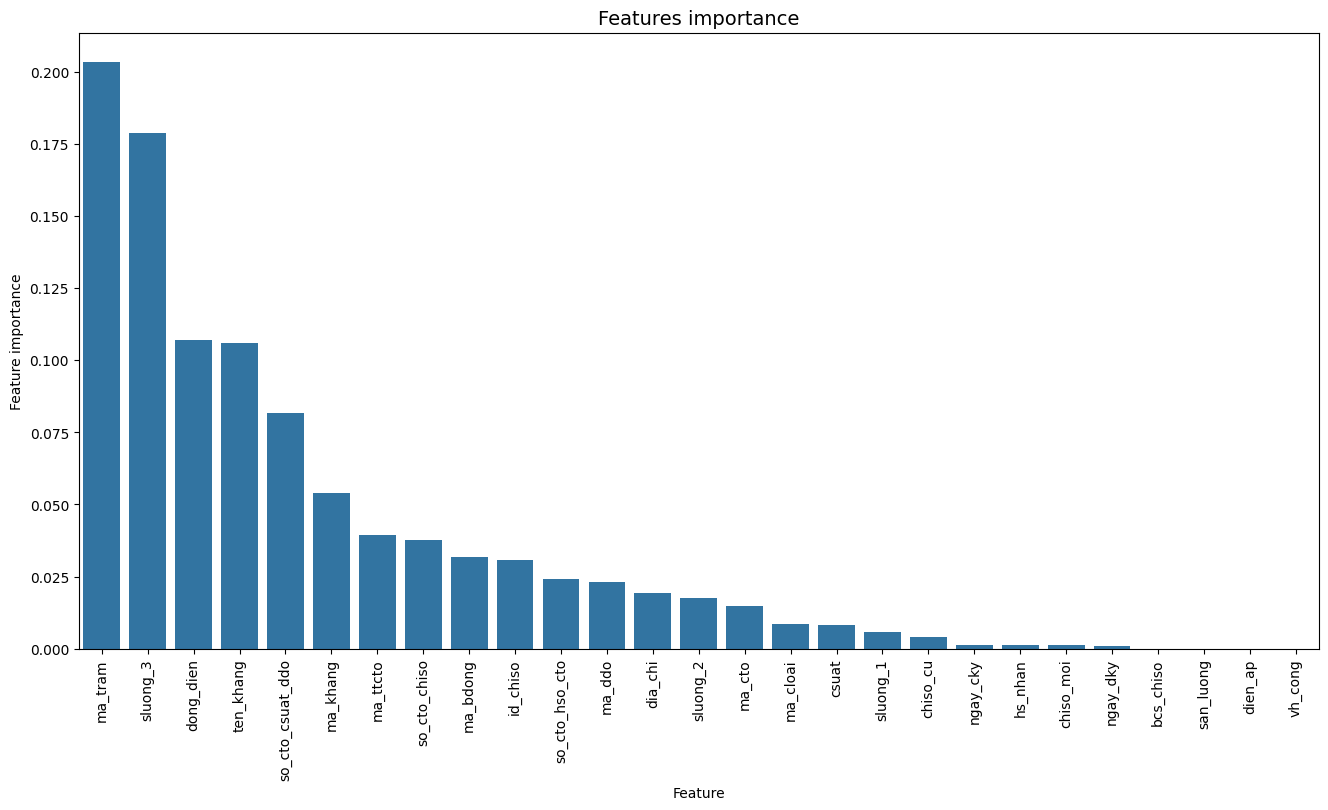

In [8]:
Features = [col for col in df.columns if col not in cols_to_drop]
print(Features)
tmp = pd.DataFrame({'Feature': Features, 'Feature importance': model_raw.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (16,8))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

preprocessing

AUC Score      : 0.93012
Custom pAUC    : 0.14339


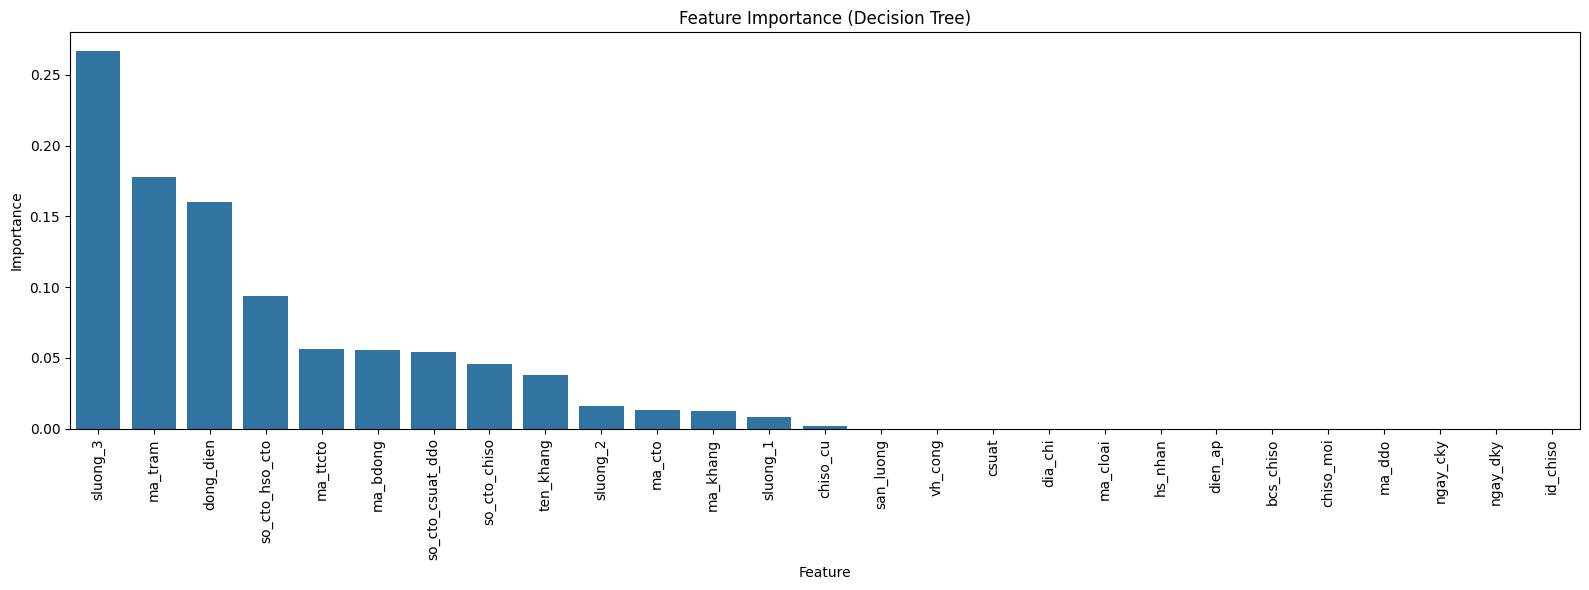

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Đọc dữ liệu
df_train = pd.read_parquet('trainn.parquet')
df_valid = pd.read_parquet('vali.parquet')
df_test  = pd.read_parquet('testt.parquet')

# 2. Cột cần loại bỏ
cols_to_drop = [
    'fraud',
    'ngay_hhluc_khang', 'ngay_hhluc_vitri_ddo', 'ngay_hhluc_diemdo', 'ngay_hhluc',
    'id_bcs', 'ngay_kdinh', 'loai_chiso', 'ngay_hluc_diem_do', 'ngay_hluc_vitri_ddo',
    'thang_csuat_ddo', 'ngay_hluc_khang', 'gia_tri', 'loai_giatri', 'kimua_cspk',
    'id_ddo', 'ma_dviqly', 'so_cot', 'so_hop', 'ma_dvictren', 'ky', 'thang', 'nam',
    'sluong_ttiep', 'sluong_trphu', 'thd_le', 'ma_cnang_chiso', 'ngay_bdong',
    'id_khang', 'so_pha', 'ngay_tao_chiso', 'nguoi_tao_chiso', 'ngay_sua_chiso',
    'nguoi_sua_chiso', 'ngay_hluc'
]

# 3. Tách X, y
X_train = df_train.drop(columns=cols_to_drop)
y_train = df_train['fraud']
X_valid = df_valid.drop(columns=cols_to_drop)
y_valid = df_valid['fraud']
X_test = df_test.drop(columns=cols_to_drop)
y_test = df_test['fraud']

# 4. Mã hóa object
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[cat_cols] = oe.fit_transform(X_train[cat_cols].astype(str))
X_valid[cat_cols] = oe.transform(X_valid[cat_cols].astype(str))
X_test[cat_cols]  = oe.transform(X_test[cat_cols].astype(str))

# 5. Huấn luyện với Decision Tree
model = DecisionTreeClassifier(
    criterion='gini',        # Hoặc 'entropy'
    max_depth=6,             # Giới hạn độ sâu của cây
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
model.fit(X_train, y_train)

# 6. Dự đoán
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# 7. Hàm custom partial AUC
def custom_metric(y_true, y_pred_proba):
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    v_gt = abs(y_true - 1)
    v_pred = 1.0 - np.array(y_pred_proba)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / 0.5 * (partial_auc_scaled - 0.5)
    return partial_auc

# 8. Đánh giá
print(f"AUC Score      : {roc_auc_score(y_test, y_pred_proba):.5f}")
print(f"Custom pAUC    : {custom_metric(y_test, y_pred_proba):.5f}")

# 9. Vẽ biểu đồ độ quan trọng
features = X_train.columns
tmp = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
tmp = tmp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(16, 6))
sns.barplot(x='Feature', y='Importance', data=tmp)
plt.xticks(rotation=90)
plt.title('Feature Importance (Decision Tree)')
plt.tight_layout()
plt.show()
